# Universidad de Buenos Aires
# Aprendizaje Profundo - TP1
# Cohorte 20 - 3er bimestre 2025


Este primer TP comienza la semana de la clase 2 y la ventana de entrega estará abierta hasta las **23hs del jueves 31 de julio (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP1 EQUIVALE AL 60% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/2UKBgNLjBZZ5XCeH9)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **PREGUNTA 1**

## **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

\\

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).

\\

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde \\( w \\) y \\( b \\) son los parámetros a optimizar.

\\

Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

`x = np.linspace(ini, fin, n)`

donde `x` es un array de una sola dimensión y con `n` cantidad de valores. Y tiene un rango de valores desde `ini` hasta `fin`. Recomiendo que sea simétrico, es decir, los mismos valores solo que con el signo cambiado, por ejemplo `ini=-3, fin=3`.

\\

Y con un target `y`:

`y = funcion_no_lineal(x) + ruido`

donde `y` es también un vector de una sola dimensión de tamaño `n` que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete `np.random`.


### 1a) Implementación del Gradiente Descendente (1 punto)
- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar \\( J(w, b) \\).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de \\( w \\) y \\( b \\) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época

\\

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [120]:
from typing import Literal, Optional, Dict, List
import numpy as np
from matplotlib import pyplot as plt

In [137]:
class SimplePerceptron:
    """
    A simple implementation of a single neuron perceptron. With parametrizable
    input and one output. The activation function is the hyperbolic tangent
    function (tanh) by default.
    """
    def __init__(
        self, 
    ):
        """
        Init method for the perceptron.

        Parameters
        ----------
        learning_rate: float
            Learning rate for the perceptron.
        activation_fun: Callable
            Activation function to be used in the output.
        """
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        self._activation_fun = np.tanh
        self._lr: float = None

    def _reset_weights(self):
        """
        Resets the weights and bias of the perceptron to random values.
        """
        self.weight = np.random.rand(len(self.weight))
        self.bias = np.random.rand(1)

    @staticmethod
    def batch_generator(X, y, batch_size=32, shuffle=True):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)

        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            yield X[batch_indices], y[batch_indices]

    def train(
        self, 
        inputs: np.ndarray, 
        targets: np.ndarray,
        epochs: int,
        lr: float,
        optim: Optional[Literal['adam']] = None,
        batch_size: Optional[int] = None,
        checkpoint: bool = False):
        """
        Trains the perceptron using the provided inputs and targets.

        Parameters
        ----------
        inputs: np.ndarray
            Input data to perform the forward pass.
        targets: np.ndarray
            Target output.
        epochs: int
            Number of epochs.
        lr: float
            Learning rate for the training.
        optim: Optional[Literal['adam']]
            Optimization algorithm to be used. Currently only adam is supported.
            If None, no optimization is applied and the perceptron will use a
            gradient descent update.
        checkpoint: bool
            If True, retrains on top of the wheights and bias of the perceptron.
            If False, the perceptron will be re initialized with random weights
            and bias.
        
        Mutates
        -------
        self.weights: np.ndarray
            Updates the weights of the perceptron.
        self.bias: float
            Updates the bias of the perceptron.
        """
        assert inputs.shape[0] == targets.shape[0], "mismatched input and target sizes"
        
        # mse per epoch
        self.mse = list()

        # Reset weights and bias if not checkpointing
        if not checkpoint:
            self._reset_weights()

        if optim == 'adam':
            r_w, v_w = np.zeros_like(self.weight), np.zeros_like(self.weight)
            r_b, v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
            p1, p2  = 0.9, 0.999

        _batch_size = len(inputs) if batch_size is None else batch_size
        for epoch in range(epochs):
            
            self.mse.append(0)

            # create batches
            for x_batch, y_batch in self.batch_generator(
                X=inputs, y=targets, batch_size=_batch_size, shuffle=False):

                # Forward pass
                output = self.predict(inputs=x_batch)

                # Calculate the loss (mean squared error)
                error = np.mean(np.power(y_batch - output, 2))
                self.mse[-1] += error.item()  # Convert to scalar
                
                # Derivative of the loss with respect to the output
                grad = -2 * (y_batch - output) * (1 - output ** 2)
                grad_w = np.mean(grad * x_batch)
                grad_b = np.mean(grad)

                if optim is None:
                    # Gradient descent update
                    self.weight -= lr * grad_w
                    self.bias -= lr * grad_b

                elif optim == 'adam':
                    # Momentum update for weights
                    v_w = p1 * v_w + (1 - p1) * grad_w
                    r_w = p2 * r_w + (1 - p2) * (grad_w ** 2)
                    # Momentum update for bias
                    v_b = p1 * v_b + (1 - p1) * grad_b
                    r_b = p2 * r_b + (1 - p2) * (grad_b ** 2)                    
                    self.weight -= lr * v_w / (np.sqrt(r_w) + 1e-8)  # Adding epsilon to avoid division by zero
                    self.bias -= lr * v_b / (np.sqrt(r_b) + 1e-8)
                
            self.mse[-1] /= _batch_size  # Average loss for the epoch
            print(f'Epoch {epoch + 1}/{epochs}, Avg Loss: {self.mse[-1]:.4f}')


    def predict(self, inputs: np.ndarray) -> List[float]:
        """
        Performs a forward pass through the perceptron.
        
        Parameters
        ----------
        inputs: np.ndarray
            Input data to the perceptron.
        Returns
        -------
        float
            Output of the perceptron after applying the activation function.
        """
        z = self.weight * inputs + self.bias
        return np.tanh(z)

Genero data de entrada y salida

<Figure size 640x480 with 0 Axes>

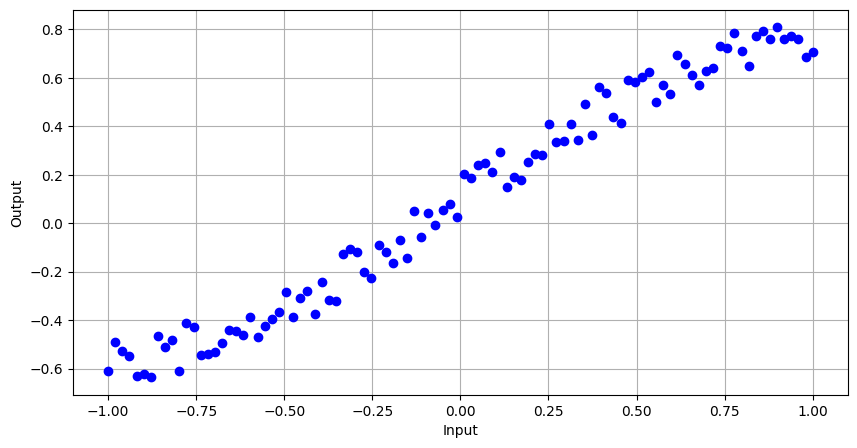

In [138]:
# for reproducibility
np.random.seed(42)

n_samples = 100
input = np.linspace(-1, 1, n_samples)
target = np.tanh(np.sin(input)) + 0.2 * np.random.rand(len(input))

plt.figure(figsize=(10, 5))
plt.plot(input, target, color='blue', marker='o', linestyle='None')
plt.title('Plot of tanh(sin(x))')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.grid()
plt.show()


Epoch 1/100, Avg Loss: 0.0012
Epoch 2/100, Avg Loss: 0.0009
Epoch 3/100, Avg Loss: 0.0007
Epoch 4/100, Avg Loss: 0.0006
Epoch 5/100, Avg Loss: 0.0004
Epoch 6/100, Avg Loss: 0.0004
Epoch 7/100, Avg Loss: 0.0003
Epoch 8/100, Avg Loss: 0.0002
Epoch 9/100, Avg Loss: 0.0002
Epoch 10/100, Avg Loss: 0.0002
Epoch 11/100, Avg Loss: 0.0001
Epoch 12/100, Avg Loss: 0.0001
Epoch 13/100, Avg Loss: 0.0001
Epoch 14/100, Avg Loss: 0.0001
Epoch 15/100, Avg Loss: 0.0001
Epoch 16/100, Avg Loss: 0.0001
Epoch 17/100, Avg Loss: 0.0001
Epoch 18/100, Avg Loss: 0.0001
Epoch 19/100, Avg Loss: 0.0001
Epoch 20/100, Avg Loss: 0.0001
Epoch 21/100, Avg Loss: 0.0001
Epoch 22/100, Avg Loss: 0.0000
Epoch 23/100, Avg Loss: 0.0000
Epoch 24/100, Avg Loss: 0.0000
Epoch 25/100, Avg Loss: 0.0000
Epoch 26/100, Avg Loss: 0.0000
Epoch 27/100, Avg Loss: 0.0000
Epoch 28/100, Avg Loss: 0.0000
Epoch 29/100, Avg Loss: 0.0000
Epoch 30/100, Avg Loss: 0.0000
Epoch 31/100, Avg Loss: 0.0000
Epoch 32/100, Avg Loss: 0.0000
Epoch 33/100, Avg

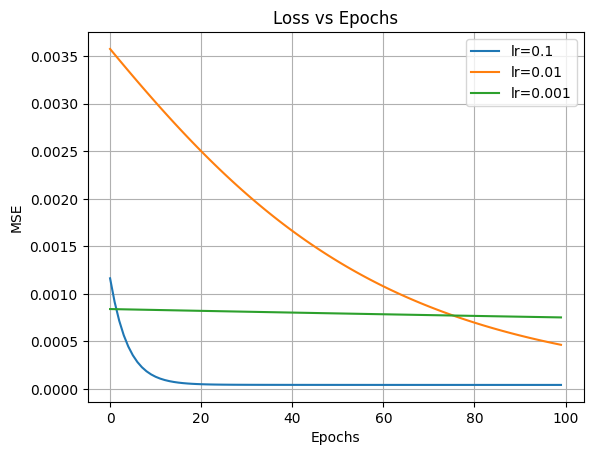

In [141]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
preds: Dict[float, List[float]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, targets=target, epochs=epochs, lr=lr, checkpoint=False)
    
    # Store the loss for each learning rate
    preds[lr] = slp.predict(inputs=input)
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

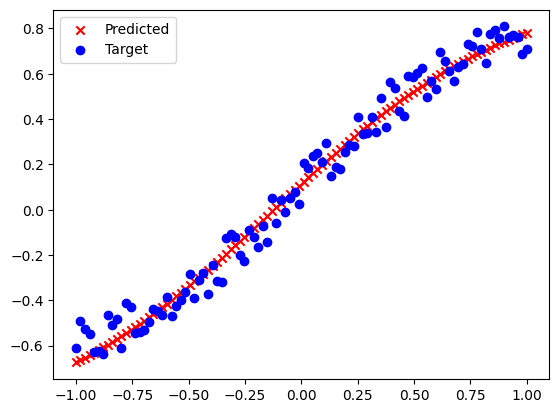

In [142]:
outputs = list()

plt.figure()
plt.scatter(input, preds[0.1], marker='x', color='red')
plt.scatter(input, target, color='blue', marker='o')
plt.legend(['Predicted', 'Target'])
plt.show()

### 1b) Implementación de Adam (1 punto)  
- Implementar el algoritmo de Adam para minimizar \\( J(w, b) \\).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de \\( w \\) y \\( b \\) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época
- Hacer 2 modelos, uno sin mini-batch (full-batch) y otro con mini-batch (batch size a elección de ustedes).

\\

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

Entrenamos usando full batch:

Epoch 1/100, Avg Loss: 0.0033
Epoch 2/100, Avg Loss: 0.0009
Epoch 3/100, Avg Loss: 0.0003
Epoch 4/100, Avg Loss: 0.0009
Epoch 5/100, Avg Loss: 0.0016
Epoch 6/100, Avg Loss: 0.0019
Epoch 7/100, Avg Loss: 0.0018
Epoch 8/100, Avg Loss: 0.0015
Epoch 9/100, Avg Loss: 0.0011
Epoch 10/100, Avg Loss: 0.0008
Epoch 11/100, Avg Loss: 0.0007
Epoch 12/100, Avg Loss: 0.0007
Epoch 13/100, Avg Loss: 0.0008
Epoch 14/100, Avg Loss: 0.0010
Epoch 15/100, Avg Loss: 0.0008
Epoch 16/100, Avg Loss: 0.0004
Epoch 17/100, Avg Loss: 0.0001
Epoch 18/100, Avg Loss: 0.0002
Epoch 19/100, Avg Loss: 0.0005
Epoch 20/100, Avg Loss: 0.0006
Epoch 21/100, Avg Loss: 0.0003
Epoch 22/100, Avg Loss: 0.0001
Epoch 23/100, Avg Loss: 0.0001
Epoch 24/100, Avg Loss: 0.0002
Epoch 25/100, Avg Loss: 0.0003
Epoch 26/100, Avg Loss: 0.0003
Epoch 27/100, Avg Loss: 0.0002
Epoch 28/100, Avg Loss: 0.0001
Epoch 29/100, Avg Loss: 0.0001
Epoch 30/100, Avg Loss: 0.0001
Epoch 31/100, Avg Loss: 0.0002
Epoch 32/100, Avg Loss: 0.0001
Epoch 33/100, Avg

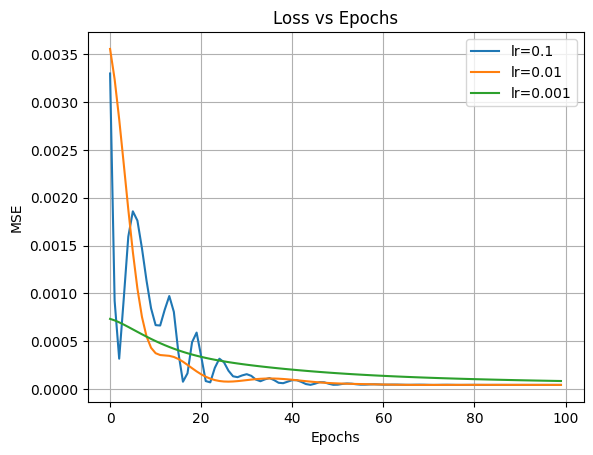

In [143]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
preds_adam_fb: Dict[float, List[float]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs, 
        lr=lr,
        checkpoint=False, 
        optim='adam')
    
    # Store the loss for each learning rate
    preds_adam_fb[lr] = slp.predict(inputs=input)
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Adam con minibatch de N muestras:

Epoch 1/100, Avg Loss: 0.0508
Epoch 2/100, Avg Loss: 0.0306
Epoch 3/100, Avg Loss: 0.0372
Epoch 4/100, Avg Loss: 0.0394
Epoch 5/100, Avg Loss: 0.0333
Epoch 6/100, Avg Loss: 0.0244
Epoch 7/100, Avg Loss: 0.0154
Epoch 8/100, Avg Loss: 0.0044
Epoch 9/100, Avg Loss: 0.0079
Epoch 10/100, Avg Loss: 0.0010
Epoch 11/100, Avg Loss: 0.0029
Epoch 12/100, Avg Loss: 0.0017
Epoch 13/100, Avg Loss: 0.0016
Epoch 14/100, Avg Loss: 0.0015
Epoch 15/100, Avg Loss: 0.0010
Epoch 16/100, Avg Loss: 0.0013
Epoch 17/100, Avg Loss: 0.0012
Epoch 18/100, Avg Loss: 0.0012
Epoch 19/100, Avg Loss: 0.0011
Epoch 20/100, Avg Loss: 0.0011
Epoch 21/100, Avg Loss: 0.0011
Epoch 22/100, Avg Loss: 0.0011
Epoch 23/100, Avg Loss: 0.0011
Epoch 24/100, Avg Loss: 0.0011
Epoch 25/100, Avg Loss: 0.0011
Epoch 26/100, Avg Loss: 0.0011
Epoch 27/100, Avg Loss: 0.0011
Epoch 28/100, Avg Loss: 0.0011
Epoch 29/100, Avg Loss: 0.0011
Epoch 30/100, Avg Loss: 0.0011
Epoch 31/100, Avg Loss: 0.0011
Epoch 32/100, Avg Loss: 0.0011
Epoch 33/100, Avg

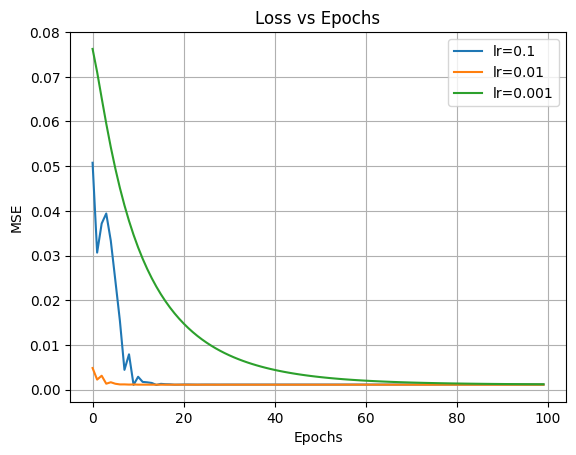

In [144]:
batch_size = 20

preds_adam_mini_batch: Dict[float, List[float]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        checkpoint=False, 
        optim='adam')
    
    # Store the loss for each learning rate
    preds_adam_fb[lr] = slp.predict(inputs=input)
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

### 1c) Comparativa de optimizadores (0.5 puntos)  
- Comparar el resultado y rendimiento de GD VS Adam (full-batch) VS Adam (mini-batch) para cada uno de los learning rates.
- Redactar conclusiones analíticas que resalten las diferencias entre cada optimizador.

### 1d) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)
- Graficar en 3D la trayectoria del aprendizaje de los 3 optimizadores sobre la superficie de la función de costo \\( J(w, b) \\). Se debe elegir un solo learning rate.
- Comparar y redactar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

# **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones, compuestas por un cliente y el producto que adquirió.


### 2a) EDA y preparación del dataset (2.5 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar y transformar las variables que sean necesarias, analizar qué columnas se deben dropear, cuáles vale la pena hacer un tratamiento de valores nulos, si se debe usar label encoding, one-hot encoding o mapping encoding, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a un segmento: "Casual" (gasta menos de 3000), "Gama media" (gasta entre 3000 y 8000), "Gama alta" (gasta entre 8000 y 18000) o a "Premium" (gasta más de 18000), según el producto que adquirió.

Redactar las conclusiones preliminares que pueden notar de las columnas y justificar el porqué de cada encoding aplicado.

**IMPORTANTE: Luego de asignar los segmentos, no se olviden de eliminar la columna "Purchase".**

### 2b) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y validation. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 77% de accuracy y f1 score para el set de validation.

### 2c) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y test. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Justificar la cantidad de dimensiones usada para los embeddings. **Comparar contra el modelo sin embeddings** y explicar el porqué de los resultados.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 90% de accuracy y f1 score para el set de validation.

### 2d) Encontrar usuarios similares (1 punto)
Para el modelo del punto 2c) implementar una función que reciba un ID de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar. También se debe mostrar el grado o porcentaje de similitud de cada usuario que retorne la función.